# CIFAR-10 이미지 생성모델 만들기

CGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 보기

## 들어가기 전에


``` teminal 
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 

생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.         

이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 

시각화 과정에서 고려할 점이 있습니다.


입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

In [4]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


## 데이터셋 구성 
CIFAR-10은 keras datasets에 포함되어있습니다.

In [93]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [94]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


우리는 y값이 필요없기 때문에 y값은 _로 불러옵니다.

한번 이미지를 확인해 보겠습니다. 

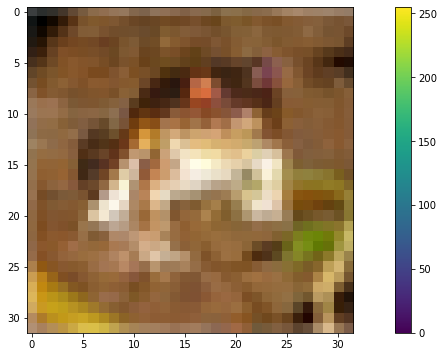

In [95]:
plt.imshow(train_x[0].reshape(32, 32,-1), cmap='viridis')
plt.colorbar()
plt.show()

처음에 뭔가했는데 frog라고 합니다. 

학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
그후 정규화된 데이터를 시각화를 통해 확인해 봅겠습니다.


In [96]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다. # 127.5는 1

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [97]:
train_x.shape

(50000, 32, 32, 3)

In [98]:
train_x[0]

array([[[-0.5372549 , -0.51372549, -0.50588235],
        [-0.6627451 , -0.63921569, -0.64705882],
        [-0.60784314, -0.62352941, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215686, -0.01960784, -0.2       ],
        [ 0.16078431, -0.02745098, -0.19215686]],

       [[-0.8745098 , -0.84313725, -0.84313725],
        [-1.        , -1.        , -1.        ],
        [-0.85882353, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980392, -0.56862745],
        [-0.06666667, -0.34901961, -0.60784314],
        [-0.04313725, -0.31764706, -0.55294118]],

       [[-0.80392157, -0.81176471, -0.83529412],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.61568627, -0.78823529, -0.9372549 ],
        ...,
        [-0.0745098 , -0.34117647, -0.60784314],
        [-0.05882353, -0.34117647, -0.60784314],
        [-0.14509804, -0.42745098, -0.67058824]],

       ...,

       [[ 0.63137255,  0.33333333, -0.24705882],
        [ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


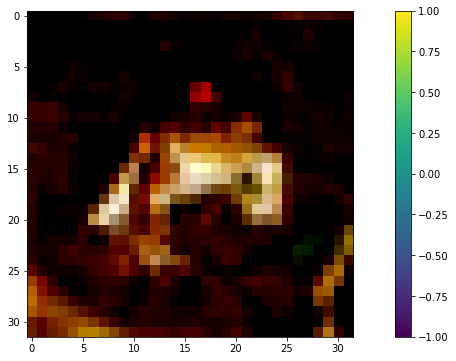

In [99]:
plt.imshow(train_x[0].reshape(32, 32,-1).astype('float32'),vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


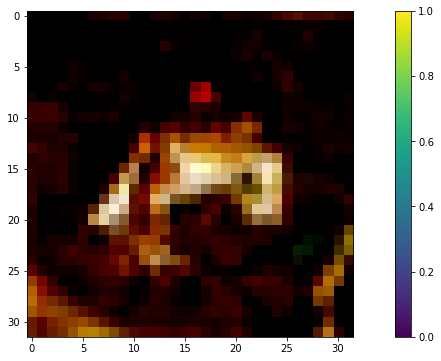

In [100]:
plt.imshow(train_x[0].reshape(32, 32,-1).astype('float32'))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

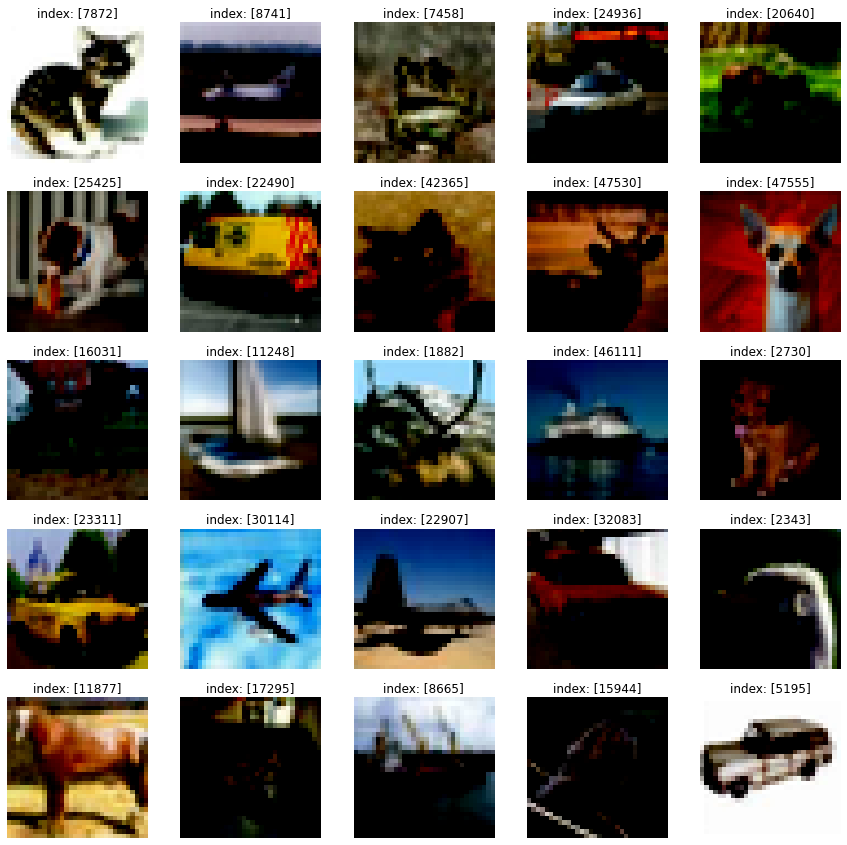

In [101]:
plt.figure(figsize=(15, 15))

for i in range(25):
    plt.subplot(5, 5, i+1)
    rand_index = np.random.randint(0, 50000,1)
    plt.imshow(train_x[rand_index].reshape(32, 32,-1))
    plt.title(f'index: {rand_index}')
    plt.axis('off')

plt.show()

이미지를 확인할 수 있었습니다.

## 데이터셋 형성

In [102]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [103]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

[tf.data.Dataset 텐서플로우 공식문서 ](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)

## generator 모델 구현

In [104]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First : Dense layer 
    
    model.add(layers.Dense(8 * 8 * 256, use_bias = False, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # second:Rehape layer
    
    model.add(layers.Reshape((8,8,256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size = (5,5), strides = (2,2), padding = 'same', 
                                    use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size = (5,5), strides = (2,2), padding = 'same',
             use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size = (5,5), strides = (1,1), padding = 'same', use_bias = False,
                                   activation = 'tanh'))
    return model 

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.                                   
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.          
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [105]:
generator = make_generator_model()

generator.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)      

생성된 이미지가 (32,32,3) 형태임을 알아볼 수 있습니다.

In [106]:
noise = tf.random.normal([1, 100])

한번 shape(1,100)의 랜덤노이즈를 넣어 잘만들어 내는지를 확인해보겠습니다.

In [66]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [67]:
generated_image

<tf.Tensor: shape=(1, 32, 32, 3), dtype=float32, numpy=
array([[[[-6.24158978e-03,  4.79727431e-04,  2.26850715e-03],
         [-4.73559834e-03,  4.68914118e-03, -2.12165201e-03],
         [ 6.82039047e-03,  5.05194394e-03, -8.34254548e-03],
         ...,
         [-1.04332985e-02, -1.68040907e-03, -6.87685749e-03],
         [-3.31085827e-03, -1.75993412e-03, -1.30954403e-02],
         [-4.36500879e-03, -2.57572392e-05, -1.15198838e-02]],

        [[ 5.90366835e-05,  8.01878516e-03, -3.49798123e-03],
         [ 8.44580680e-03, -4.23827395e-03, -1.82363892e-03],
         [-6.53207768e-04,  2.65881815e-03,  1.10428836e-02],
         ...,
         [-1.40064191e-02,  1.36202686e-02, -1.88977513e-02],
         [-3.65143147e-04,  1.38892168e-02,  6.96443673e-03],
         [-1.34404711e-02, -5.63884526e-03, -1.55036934e-02]],

        [[-3.30531900e-03, -5.68830781e-03, -6.50761696e-03],
         [-1.30807180e-02,  4.88597574e-03, -2.06654891e-02],
         [-6.79907994e-03, -2.15390623e-02, 

In [68]:
generated_image = ( generated_image*127.5 + 127.5)  # [-1,1]의 범위를 다시 [0,255]로 변환합니다. 

In [69]:
 generated_image= tf.cast(
    generated_image,'int64', name=None
)               # 정수형태가 아니기 때문에 int64 형태로 바꿔줍니다. 

In [70]:
generated_image

<tf.Tensor: shape=(1, 32, 32, 3), dtype=int64, numpy=
array([[[[126, 127, 127],
         [126, 128, 127],
         [128, 128, 126],
         ...,
         [126, 127, 126],
         [127, 127, 125],
         [126, 127, 126]],

        [[127, 128, 127],
         [128, 126, 127],
         [127, 127, 128],
         ...,
         [125, 129, 125],
         [127, 129, 128],
         [125, 126, 125]],

        [[127, 126, 126],
         [125, 128, 124],
         [126, 124, 127],
         ...,
         [125, 128, 121],
         [127, 125, 125],
         [124, 126, 124]],

        ...,

        [[126, 126, 125],
         [127, 128, 126],
         [127, 127, 126],
         ...,
         [126, 128, 127],
         [127, 123, 127],
         [128, 127, 127]],

        [[128, 127, 126],
         [126, 126, 125],
         [124, 125, 126],
         ...,
         [126, 124, 128],
         [122, 125, 129],
         [127, 128, 125]],

        [[127, 127, 127],
         [125, 127, 126],
         [127, 127, 

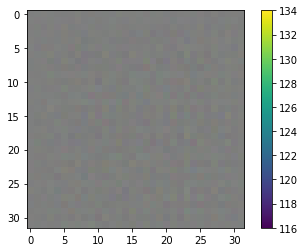

In [72]:
plt.imshow(generated_image[0, :, :, ])
plt.colorbar()
plt.show()

In [ ]:
흐릿한 이미지로 생성된것을 확인할 수 있습니다. 

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last".

data format이랑 fadding을 알아야함. 

## STEP 3. 판별자 모델 구현하기


In [ ]:
(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [107]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [108]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [109]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.1019392]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기


In [ ]:
생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
생성자와 판별자를 최적화하는 optimizer를 정의합니다.

### 손실함수

In [110]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [111]:
### generator_loss 


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [112]:
### discriminator_loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [113]:
### discriminator accuracy

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)

In [114]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [115]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 5. 훈련과정 상세 기능 구현하기


1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.           
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.             
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.                  
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.        

In [116]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [117]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/CIFAR-10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [118]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/CIFAR-10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [119]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/CIFAR-10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기


위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.           
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.                 
학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다. 


>(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음> 부터 다시 진행한다면 시간 낭비가 될 것입니다.                  

우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.                          
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.                            

In [120]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [121]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

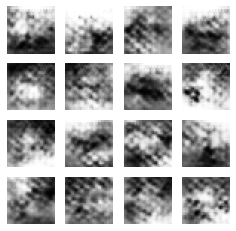

Time for training : 862 sec


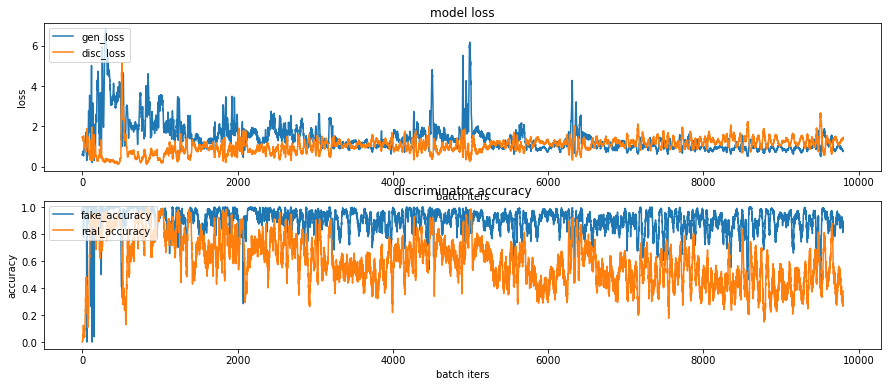

CPU times: user 14min 20s, sys: 21.6 s, total: 14min 42s
Wall time: 14min 22s


In [123]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

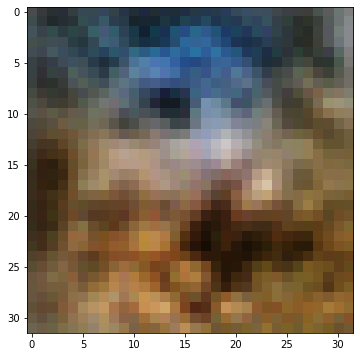

In [124]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.



In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

## STEP 7. (optional) GAN 훈련 과정 개선하기


STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.
(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

How to Train a GAN? Tips and tricks to make GANs work
10 Lessons I Learned Training GANs for one Year
Tips for Training Stable Generative Adversarial Networks
Improved Techniques for Training GANs(paper)